In [1]:
# The numerical integrators are located in a module two levels above
# the current working directory. Hence:
import sys
sys.path.insert(0, '../..')

# Package imports

In [2]:
# Numpy
import numpy as np

# Matplotlib
from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
plt.rc('figure',figsize=(18,10),dpi=100)
%matplotlib inline

# Numba (JiT)
from numba import njit

# (Primitive) timing functionality
import time 

# Multiprocessing:
import multiprocessing as mp

# Spline interpolation:
from scipy.interpolate import RectBivariateSpline

# Check whether folders exist or not, necessary
# for storing advected states:
import os
import errno

# Display progress bars:
from ipywidgets import FloatProgress
from IPython.display import display

# Deep copies
import copy

#  Function that creates directories if they don't exist

In [3]:
# Function that makes a directory if it does not exist,
# and raises an exception otherwise 
# (necessary for storing advected states)

def ensure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

# Defining the velocity field

In [4]:
@njit
def doublegyre_wrapper(t,x):
    # Parameters of the velocity field (Cf. Farazmand & Haller, 2012)
    # A
    A = 0.1
    # epsilon
    e = 0.1
    # omega
    w = 2*np.pi/10
    return _doublegyre(t,x,A,e,w)

@njit
def _doublegyre(t,x,A,e,w):
    # a(t)
    a = e * np.sin(w*t)       
    # b(t)
    b = 1 - 2*e*np.sin(w*t)  
    # f(x,t)
    f = a*x[0,:]**2 + b*x[0,:]
    # df/dx
    dfdx = 2*a*x[0,:] + b
    
    v = np.empty(x.shape)                         
    # x-component:
    v[0,:] = -np.pi*A*np.sin(np.pi*f)*np.cos(np.pi*x[1,:])
    # y-component:
    v[1,:] = np.pi*A*np.cos(np.pi*f)*np.sin(np.pi*x[1,:])*dfdx
    return v 

# Functions which generate grids of particles

In [11]:
def grid_of_particles(nx,ny,x_min,x_max,y_min,y_max):
    x = np.linspace(x_min,x_max,nx)
    y = np.linspace(y_min,y_max,ny)
    
    grid = np.empty((2,nx*ny))
    
    for j in range(n_x):
        grid[0,j*ny:(j+1)*ny] = x[j]
        grid[1,j*ny:(j+1)*ny] = y
        
    return grid

def padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max):
    x_0,dx = np.linspace(x_min,x_max,nx,retstep=True)
    y_0,dy = np.linspace(y_min,y_max,ny,retstep=True)
    
    x = np.empty(nx+4)
    x[0:2] = -2*dx, -dx
    x[2:-2] = x_0
    x[-2:] = x_max+dx, x_max+2*dx
    
    y = np.empty(ny+4)
    y[0:2] = -2*dy, -dy
    y[2:-2] = y_0
    y[-2:] = y_max+dy, y_max+2*dy
    
    nx_ = nx+4
    ny_ = ny+4
    
    grid = np.empty((2,nx_*ny_))
    
    for j in range(nx_):
        grid[0,j*ny_:(j+1)*ny_] = x[j]
        grid[1,j*ny_:(j+1)*ny_] = y
    
    return grid   

# List of implemented fixed step integrators
## Relevant for saving/loading advected states

In [6]:
fixed_step_integrators = set(['euler','rk2','rk3','rk4'])

# Function which advects a set of initial conditions, including auxiliary grid points

In [7]:
# Input: (numpy) array of coordinates, shape: (5,2,nx*ny), [grid,x,y]
def endpoints(t_start,t_end,pos_start,stride,integrator,rhs,n_proc,atol,rtol):
    pos_end = np.empty(pos_start.shape)
    
    n_tot = pos_start.shape[2]
    part = np.floor(n_tot/n_proc).astype(int)
    
    qlist = [mp.Queue() for j in range(n_proc)]
    
    if integrator.__name__ in fixed_step_integrators:
        plist = [mp.Process(target=_endpoints_fixed,
                           args=(t_start,t_end,pos_start[:,:,j*part:n_tot if j+1 is n_proc else (j+1)*part],
                                stride,integrator,rhs,j,qlist[j])) for j in range(n_proc)]
    else:
        plist = [mp.Process(target=_endpoints_adaptive,
                           args=(t_start,t_end,pos_start[:,:,j*part:n_tot if j+1 is n_proc else (j+1)*part],
                                stride,integrator,rhs,j,qlist[j],atol,rtol)) for j in range(n_proc)]
    
    for p in plist:
        p.start()
    for j, q in enumerate(qlist):
        pos_end[:,:,j*part:n_tot if j+1 is n_proc else (j+1)*part] = q.get()
    for p in plist:
        p.join()
    
    return pos_end

def _endpoints_fixed(t_start,t_end,pos_start,stride,integrator,rhs,pn,q):
    pos_fin = np.copy(pos_start)
    if t_end>t_start:
        for j in range(pos_fin.shape[0]):
            n_steps = np.ceil((t_end-t_start)/stride).astype(int)
            h = (t_end-t_start)/n_steps
            for i in range(n_steps):
                foo, pos_fin[j], bar = integrator(t_start+i*h, pos_fin[j], h, rhs)
            #t = np.copy(t_start).astype(np.float64)
            #h = np.copy(stride).astype(np.float64)
            #while t<t_end:
            #    h = np.minimum(h,t_end-t)
            #    t,pos_fin[j],h = integrator(t,pos_fin[j],h,rhs)
    else:
        for j in range(np.size(pos_fin,0)):
            n_steps = np.ceil((t_start-t_end)/stride).astype(int)
            h = -(t_start-t_end)/n_steps
            for i in range(n_steps):
                foo, pos_fin[j], bar = integrator(t_start+i*h, pos_fin[j], h, rhs)
            #t = np.copy(t_start).astype(float)
            #h = np.copy(stride).astype(float)
            #while t>t_end:
            #    h=np.sign(h)*np.minimum(np.abs(h),np.abs(t-t_end))
            #    t,pos_fin[j],h = integrator(t,pos_fin[j],h,rhs)
    q.put(pos_fin)
    
def _endpoints_adaptive(t_start,t_end,pos_start,stride,integrator,rhs,pn,q,atol,rtol):
    pos_fin = np.copy(pos_start)
    if t_end>t_start:
        for j in range(np.size(pos_fin,0)):
            t = np.ones(np.size(pos_fin[j]))*t_start
            h = np.ones(np.size(pos_fin[j]))*stride
            while np.any(t<t_end):
                h = np.minimum(h,t_end-t)
                t,pos_fin[j],h = integrator(t,pos_fin[j],h,rhs,atol,rtol)
    else:
        for j in range(np.size(pos_fin,0)):
            t = np.ones(np.size(pos_fin[j]))*t_start
            h = np.ones(np.size(pos_fin[j]))*stride
            while np.any(t>t_end):
                h = np.sign(h)*np.minimum(np.abs(h),np.abs(t-t_end))
                t,pos_fin[j],h = integrator(t,pos_fin[j],h,rhs,atol,rtol)
    q.put(pos_fin)

# Function which computes the characteristics for given grid parameters

In [8]:
def characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,stride,rhs,n_proc=4,atol=None,rtol=None):
    grid = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max)
    dx_main = (x_max-x_min)/(nx-1)
    dy_main = (y_max-y_min)/(ny-1)
    
    dx_aux = np.minimum(1e-5,dx_main*1e-2)
    dy_aux = np.minimum(1e-5,dy_main*1e-2)
    
    lmbd1,lmbd2,lapl_lmbd2,xi1,xi2,lapl_xi2 = _characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,dx_main,dy_main,dx_aux,dy_aux,integrator,stride,rhs,n_proc,atol,rtol)
    
    return grid,lmbd1,lmbd2,lapl_lmbd2,xi1,xi2,lapl_xi2

def _characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,dx_main,dy_main,dx_aux,dy_aux,integrator,stride,rhs,n_proc,atol,rtol):
    if integrator.__name__ in fixed_step_integrators:
        try:
            grid = np.load('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_h={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,stride))
            print('Precomputed advection found! Advection not necessary!')
        except IOError:
            print('Precomputed advection not found! Advection necessary!')
            # Grid: Main -> Right -> Above -> Left -> Beneath
            grid = np.empty((5,2,(nx+4)*(ny+4)))
            grid[0] = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max)
            grid[1] = grid[0]+np.array([dx_aux,0]).reshape(2,1)
            grid[2] = grid[0]+np.array([0,dy_aux]).reshape(2,1)
            grid[3] = grid[0]+np.array([-dx_aux,0]).reshape(2,1)
            grid[4] = grid[0]+np.array([0,-dy_aux]).reshape(2,1)
            
            grid = endpoints(t_start,t_end,grid,stride,integrator,rhs,n_proc,atol,rtol)
            np.save('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_h={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,stride),grid)
            print('Configuration now stored. Advection won\'t be necessary next time!')
    else:
        try:
            grid = np.load('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_atol={}_rtol={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,atol,rtol))
            print('Precomputed advection found! Advection not necessary!')
        except IOError:
            print('Precomputed advection not found! Advection necessary!')
            # Grid: Main -> Right -> Above -> Left -> Beneath
            grid = np.zeros((5,2,(nx+4)*(ny+4)))
            grid[0] = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max)
            grid[1] = grid[0]+np.array([dx_aux,0]).reshape(2,1)
            grid[2] = grid[0]+np.array([0,dy_aux]).reshape(2,1)
            grid[3] = grid[0]+np.array([-dx_aux,0]).reshape(2,1)
            grid[4] = grid[0]+np.array([0,-dy_aux]).reshape(2,1)
            
            grid = endpoints(t_start,t_end,grid,stride,integrator,rhs,n_proc,atol,rtol)
            np.save('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_atol={}_rtol={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,atol,rtol),grid)
            print('Configuration now stored. Advection won\'t be necessary next time!')
            
    tens_main,tens_aux = _find_strain_tensors(grid,nx,ny,dx_main,dy_main,dx_aux,dy_aux)
    
    lmbd1,lmbd2,xi1,xi2 = _find_characteristics(tens_main,tens_aux)
    
    lapl_lmbd2,lapl_xi2 = _find_laplacians(lmbd2,xi2,nx,ny,dx_main,dy_main)
    
    return lmbd1,lmbd2,lapl_lmbd2,xi1,xi2,lapl_xi2

def _find_strain_tensors(grid,nx,ny,dx_main,dy_main,dx_aux,dy_aux):
    grid_main = grid[0].reshape((2,nx+4,ny+4))
    grid_right = grid[1].reshape((2,nx+4,ny+4))
    grid_top = grid[2].reshape((2,nx+4,ny+4))
    grid_left = grid[3].reshape((2,nx+4,ny+4))
    grid_btm = grid[4].reshape((2,nx+4,ny+4))
    
    # Declare Jacobians
    df_m = np.empty((2,2,nx+4,ny+4))
    df_a = np.empty((2,2,nx+4,ny+4))
    
    # Use centered differencing throughout for auxiliary Jacobian:
    df_a[0,0,:,:] = (grid_right[0]-grid_left[0])/(2*dx_aux)
    df_a[0,1,:,:] = (grid_top[0]-grid_btm[0])/(2*dy_aux)
    df_a[1,0,:,:] = (grid_right[1]-grid_left[1])/(2*dx_aux)
    df_a[1,1,:,:] = (grid_top[1]-grid_btm[1])/(2*dy_aux)
    
    # Use centered differencing where applicable for main Jacobian,
    # second order backwards/forwards difference otherwise
    df_m[0,0,1:-1,:] = (grid_main[0,2:,:]-grid_main[0,0:-2,:])/(2*dx_main)
    df_m[0,0,0,:] = (-3*grid_main[0,0,:]+4*grid_main[0,1,:]-2*grid_main[0,2,:])/(2*dx_main)
    df_m[0,0,-1,:] = (3*grid_main[0,-1,:]-4*grid_main[0,-2,:]+2*grid_main[0,-3,:])/(2*dx_main)
    
    df_m[0,1,:,1:-1] = (grid_main[0,:,2:]-grid_main[0,:,0:-2])/(2*dy_main)
    df_m[0,1,:,0] = (-3*grid_main[0,:,0]+4*grid_main[0,:,1]-2*grid_main[0,:,2])/(2*dy_main)
    df_m[0,1,:,-1] = (3*grid_main[0,:,-1]-4*grid_main[0,:,-2]+2*grid_main[0,:,-3])/(2*dy_main)
    
    df_m[1,0,1:-1,:] = (grid_main[1,2:,:]-grid_main[1,0:-2,:])/(2*dx_main)
    df_m[1,0,0,:] = (-3*grid_main[1,0,:]+4*grid_main[1,1,:]-2*grid_main[1,2,:])/(2*dx_main)
    df_m[1,0,-1,:] = (3*grid_main[1,-1,:]-4*grid_main[1,-2,:]+2*grid_main[1,-3,:])/(2*dx_main)
    
    df_m[1,1,:,1:-1] = (grid_main[1,:,2:]-grid_main[1,:,0:-2])/(2*dy_main)
    df_m[1,1,:,0] = (-3*grid_main[1,:,0]+4*grid_main[1,:,1]-2*grid_main[1,:,2])/(2*dy_main)
    df_m[1,1,:,-1] = (3*grid_main[1,:,-1]-4*grid_main[1,:,-2]+2*grid_main[1,:,-3])/(2*dy_main)
    
    # Reshape Jacobian arrays:
    df_a = df_a.reshape((2,2,(nx+4)*(ny+4)))
    df_m = df_m.reshape((2,2,(nx+4)*(ny+4)))
    
    # Declare strain tensors:
    c_m = np.empty(np.shape(df_m))
    c_a = np.empty(np.shape(df_a))
    
    # Explicitly calculate strain tensors:
    for j in range((nx+4)*(ny+4)):
        c_m[:,:,j] = np.dot(df_m[:,:,j].T,df_m[:,:,j])
        c_a[:,:,j] = np.dot(df_a[:,:,j].T,df_a[:,:,j])
        
    return c_m,c_a

def _find_characteristics(tens_main,tens_aux):
    lmbd1 = np.empty(np.size(tens_main,2))
    lmbd2 = np.empty(np.shape(lmbd1))
    xi1 = np.empty((2,np.size(tens_main,2)))
    xi2 = np.empty(np.shape(xi1))
    
    for j in range(np.size(lmbd1)):
        # Linalg.eigh returns eigenvalues and vectors
        # sorted by increasing magnitude of eigenvalues
        vals, foo = np.linalg.eigh(tens_main[:,:,j])
        bar, vecs = np.linalg.eigh(tens_aux[:,:,j])
        
        lmbd1[j] = vals[0]
        lmbd2[j] = vals[1]
        
        xi1[:,j] = vecs[:,0]
        xi2[:,j] = vecs[:,1]
    
    return lmbd1,lmbd2,xi1,xi2

def _find_laplacians(lmbd,xi,nx,ny,dx_main,dy_main):
    lmbd_ = lmbd.reshape((nx+4,ny+4))
    xi_ = xi.reshape((2,nx+4,ny+4))
    
    lapl_lmbd = np.empty(np.shape(lmbd_))
    lapl_xi = np.empty(np.shape(xi_))
    
    # First direction:
    # Use centered differencing for internal points
    lapl_lmbd[1:-1,:] = (lmbd_[2:,:]-2*lmbd_[1:-1,:]+lmbd_[0:-2,:])/(dx_main**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl_lmbd[0,:] = (2*lmbd_[0,:]-5*lmbd_[1,:]+4*lmbd_[2,:]-lmbd_[3,:])/(dx_main**2)
    lapl_lmbd[-1,:] = (2*lmbd_[-1,:]-5*lmbd_[-2,:]+4*lmbd_[-3,:]-lmbd_[-4,:])/(dx_main**2)
    
    # Second direction:
    # Use centered differencing for internal points
    lapl_lmbd[:,1:-1] += (lmbd_[:,2:]-2*lmbd_[:,1:-1]+lmbd_[:,0:-2])/(dy_main**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl_lmbd[:,0] += (2*lmbd_[:,0]-5*lmbd_[:,1]+4*lmbd_[:,2]-lmbd_[:,3])/(dy_main**2)
    lapl_lmbd[:,-1] += (2*lmbd_[:,-1]-5*lmbd_[:,-2]+4*lmbd_[:,-3]-lmbd_[:,-4])/(dy_main**2)
    
    # First direction:
    # Use centered differencing for internal points
    lapl_xi[:,1:-1,:] = (xi_[:,2:,:]-2*xi_[:,1:-1,:]+xi_[:,0:-2,:])/(dx_main**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl_xi[:,0,:] = (2*xi_[:,0,:]-5*xi_[:,1,:]+4*xi_[:,2,:]-xi_[:,3,:])/(dx_main**2)
    lapl_xi[:,-1,:] = (2*xi_[:,-1,:]-5*xi_[:,-2,:]+4*xi_[:,-3,:]-xi_[:,-4,:])/(dx_main**2)
    
    # Second direction:
    # Use centered differencing for internal points
    lapl_xi[:,:,1:-1] += (xi_[:,:,2:]-2*xi_[:,:,1:-1]+xi_[:,:,0:-2])/(dy_main**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl_xi[:,:,0] += (2*xi_[:,:,0]-5*xi_[:,:,1]+4*xi_[:,:,2]-xi_[:,:,3])/(dy_main**2)
    lapl_xi[:,:,-1] += (2*xi_[:,:,-1]-5*xi_[:,:,-2]+4*xi_[:,:,-3]-xi_[:,:,-4])/(dy_main**2)
    
    lapl_lmbd = lapl_lmbd.reshape((nx+4)*(ny+4))
    lapl_xi = lapl_xi.reshape((2,(nx+4)*(ny+4)))
    
    return lapl_lmbd,lapl_xi
    

# Define transport parameters

In [9]:
from numerical_integrators.singlestep import rk4
t_start = 0.
t_end = 20.
h = 0.1


integrator = rk4

# Create output directory for precomputed characteristics, if it does not already exist:
ensure_path_exists('precomputed_advection/{}'.format(integrator.__name__))



x_min,x_max = 0,2
y_min,y_max = 0,1

nx,ny = 1000,500

# Perform transport

In [12]:
grid_,lmbd1_,lmbd2_,lapl_lmbd2_,xi1_,xi2_,lapl_xi2_ = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,h,doublegyre_wrapper)

_inner_mask = np.zeros((nx+4,ny+4),dtype=np.bool)
_inner_mask[2:-2,2:-2] = True
_inner_mask = _inner_mask.reshape((nx+4)*(ny+4))

grid = grid_[:,_inner_mask]
x_ = grid_[0,::ny+4]
y_ = grid_[1,:ny+4]
x = x_[2:-2]
y = y_[2:-2]
lmbd1 = lmbd1_[_inner_mask]
lmbd2 = lmbd2_[_inner_mask]
lapl_lmbd2 = lapl_lmbd2_[_inner_mask]
xi1 = xi1_[:,_inner_mask]
xi2 = xi2_[:,_inner_mask]
lapl_xi2 = lapl_xi2_[:,_inner_mask]

Precomputed advection found! Advection not necessary!


# Functions for identifying (A,B)-domain

In [13]:
def find_ab_mask(lmbd1,lmbd2,lapl_lmbd2,xi2,lapl_xi2):
    a = _a_true(lmbd1,lmbd2)
    b = _b_true(lapl_lmbd2,xi2)
    return np.logical_and(a,b)

def _a_true(lmbd1,lmbd2):
    return np.logical_and(np.less(lmbd1,lmbd2),np.greater(lmbd2,1))

def _b_true(lapl_lmbd2,xi2):
    return np.less_equal(np.sum(xi2*lapl_lmbd2*xi2,axis=0),0)

def _b_true2(lmbd2,lapl_lmbd2,xi2,lapl_xi2):
    return np.less_equal(np.sum(xi2*(lapl_lmbd2*xi2+lmbd2*lapl_xi2),axis=0),0)

def find_ab_mask2(lmbd1,lmbd2,lapl_lmbd2,xi2,lapl_xi2):
    a = _a_true(lmbd1,lmbd2)
    b2 = _b_true2(lmbd2,lapl_lmbd2,xi2,lapl_xi2)
    return np.logical_and(a,b2)

# Find (A,B)-domain

In [14]:
mask_ab = find_ab_mask(lmbd1,lmbd2,lapl_lmbd2,xi2,lapl_xi2)
mask_ab2 = find_ab_mask2(lmbd1,lmbd2,lapl_lmbd2,xi2,lapl_xi2)

# Plot (A,B)-domain

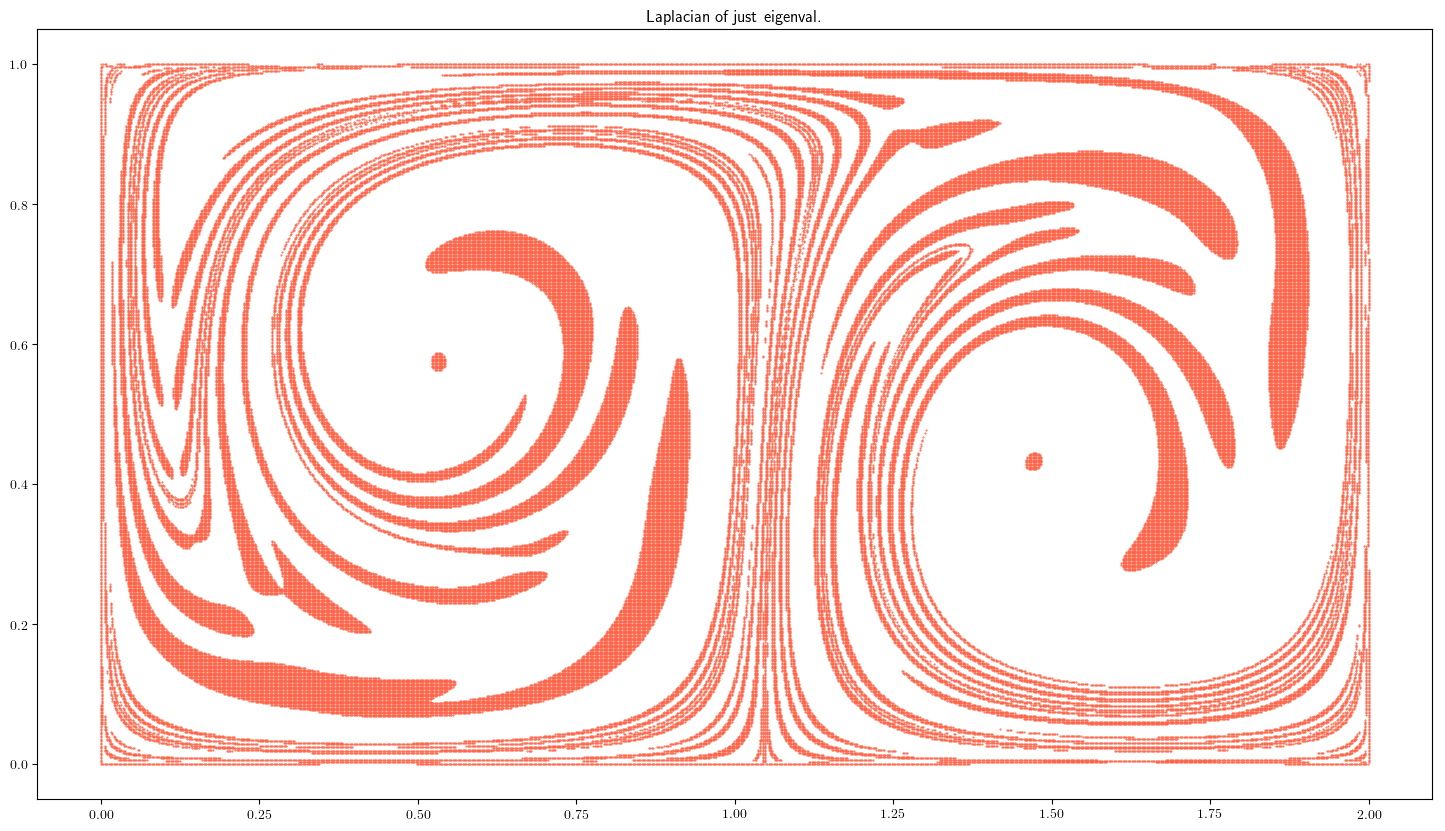

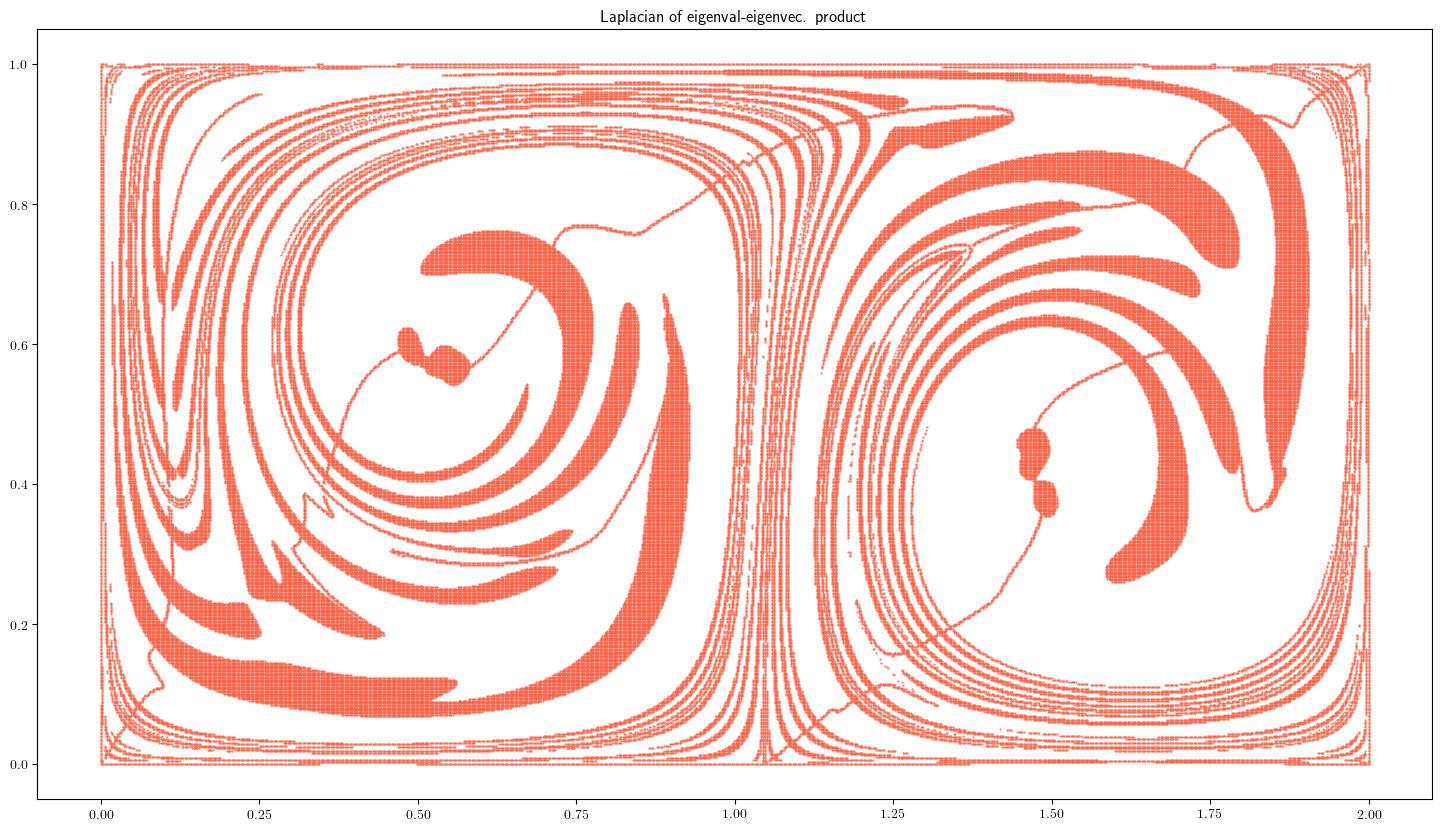

In [15]:
plt.figure()
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],s=1,marker='.',c='tomato')
plt.title('Laplacian of just eigenval.')

plt.figure()
plt.scatter(grid[0,mask_ab2],grid[1,mask_ab2],s=1,marker='.',c='tomato')
plt.title('Laplacian of eigenval-eigenvec. product')

# Function which finds $\mathcal{G}_0$

In [16]:
def find_g0(nx,ny,num_horz,num_vert):
    mask = np.zeros((nx,ny),dtype=bool)
    stride_horz = np.floor(nx/(num_horz+1)).astype(int)
    stride_vert = np.floor(ny/(num_vert+1)).astype(int)
    
    for j in range(1,num_vert+1):
        mask[np.minimum(j*stride_horz,nx-1),:] = True
    for j in range(1,num_horz+1):
        mask[:,np.minimum(j*stride_vert,ny-1)] = True
    
    mask = mask.reshape(nx*ny)
    
    return mask

# Choose no. of vert. and horz. lines in $\mathcal{G}_{0}$

In [20]:
num_horz_g0 = 4
num_vert_g0 = 4

# Find $\mathcal{G}_0$

In [22]:
g0 = grid[:,np.logical_and(find_g0(nx,ny,num_horz_g0,num_vert_g0),mask_ab)]

# Plot $\mathcal{G}_0$

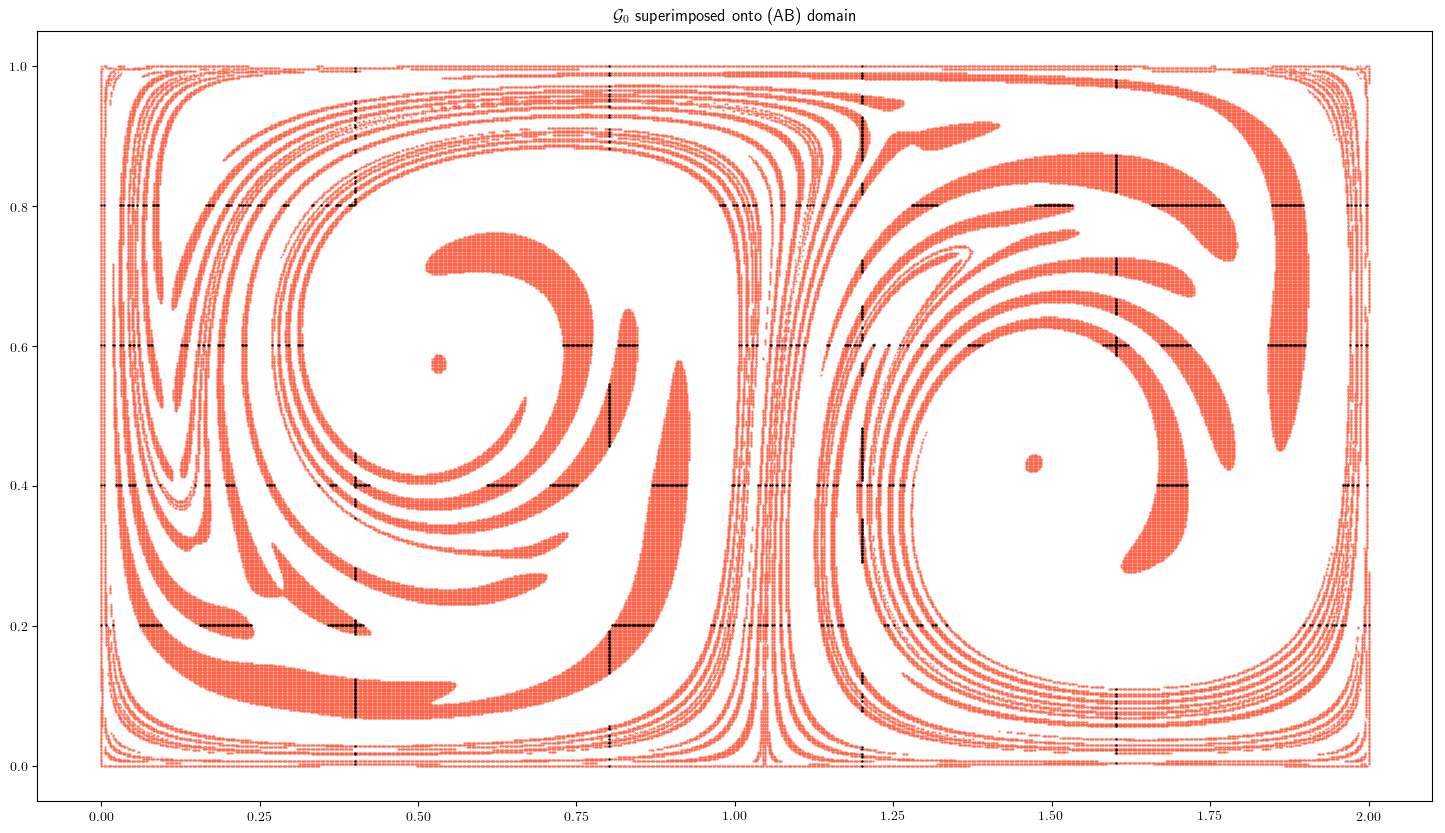

In [23]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],marker='.',s=1,c='tomato')
plt.scatter(g0[0],g0[1],marker='.',s=2,c='k')
plt.title(r'$\mathcal{G}_{0}$ superimposed onto (AB) domain')

# Functions returning derivatives and evaluating whether or not a point is within the numerical definition domain, as well as the (A,B)-domain

In [24]:
class LinearSpecialDerivative:
    def __init__(self,grid,xi):
        self.grid = grid
        self.dx = self.grid[0,1,0]-self.grid[0,0,0]
        self.dy = self.grid[1,0,1]-self.grid[1,0,0]
        self.xi = xi
        self.prev = None
        self.reverse = False
    def clear_previous(self):
        self.prev = None
    def set_previous(self,prev):
        self.prev = prev
    def flip(self):
        self.reverse = True
    def flip_back(self):
        self.reverse = False
    def __call__(self,pos):
        
        if pos[0] > x_max + self.dx:
            pos[0] = x_max + self.dx
        elif pos[0] < x_min - self.dx:
            pos[0] = x_min - self.dx
        
        if pos[1] > y_max + self.dy:
            pos[1] = y_max + self.dy
        elif pos[1] < y_min - self.dy:
            pos[1] = y_min - self.dy
        
        i = int(np.maximum(0,np.minimum(pos[0]/self.dx,np.size(self.grid,1)-2)))
        j = int(np.maximum(0,np.minimum(pos[1]/self.dy,np.size(self.grid,2)-2)))

        
        subxi = self.xi[:,i:i+2,j:j+2]

        # Choose pivot vector and fix directions of others based on this one
        for ii in range(2):
            for jj in range(2):
                if ii == 0 and jj == 0:
                    pass
                else:
                    dp = np.sign(np.dot(subxi[:,0,0],subxi[:,ii,jj]))
                    if dp < 0:
                        subxi[:,ii,jj] = - subxi[:,ii,jj]
                    #subxi[:,ii,jj] = np.sign(np.dot(subxi[:,0,0],subxi[:,ii,jj])) * subxi[:,ii,jj]
                    
        wr = (pos[0]-i*self.dx)/self.dx
        wl = 1-wr
        wt = (pos[1]-j*self.dy)/self.dy
        wb = 1-wt
        
        xi = wl*(wb*subxi[:,0,0]+wt*subxi[:,0,1])+wr*(wb*subxi[:,1,0]+wt*subxi[:,1,1])
        # Normalize xi
        xi = xi / np.sqrt(xi[0]**2+xi[1]**2)
        
        if self.prev is None:
            if not self.reverse:
                sign = 1.
            else:
                sign = -1.
        else:
            sign = -1. if np.sign(np.dot(self.prev,xi)) < 0 else 1.
        return sign*xi
    
class InABDomain:
    def __init__(self,pos_init,lmbd1,lmbd2,lapl_lmbd2,xi2,x_min,x_max,y_min,y_max,padding_factor=0.01):
        self._lmbd1_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd1.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._lmbd2_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd2.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._lapl_lmbd2_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lapl_lmbd2.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._xi2_x_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],xi2[0].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._xi2_y_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],xi2[1].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        
    def __call__(self,pos):
        lmbd1 = self._lmbd1_spline.ev(pos[1],pos[0])
        lmbd2 = self._lmbd2_spline.ev(pos[1],pos[0])
        lapl_lmbd2 = self._lapl_lmbd2_spline.ev(pos[1],pos[0])
        xi2 = np.array([self._xi2_x_spline.ev(pos[1],pos[0]),self._xi2_y_spline.ev(pos[1],pos[0])])
        xi2 = xi2/np.sqrt(xi2[0]**2+xi2[1]**2)
        return ((lmbd1 is not lmbd2) and (lmbd2 > 1) and (np.dot(xi2,lapl_lmbd2*xi2) <= 0))
    
class InNumericalDomain:
    def __init__(self,x_min,x_max,y_min,y_max,nx,ny):
        dx = (x_max-x_min)/(nx-1)
        dy = (y_max-y_min)/(ny-1)
        self._x_min = x_min-dx
        self._x_max = x_max+dx
        self._y_min = y_min-dy
        self._y_max = y_max+dx
    
    def __call__(self,pos):
        return pos[0] >= self._x_min and pos[0] <= self._x_max and pos[1] >= self._y_min and pos[1] <= self._y_max
    
class Alpha:
    def __init__(self,lmbd1_spline,lmbd2_spline):
        self.lmbd1_spline = lmbd1_spline
        self.lmbd2_spline = lmbd2_spline
    def __call__(self,pos):
        lmbd1 = self.lmbd1_spline.ev(pos[1],pos[0])
        lmbd2 = self.lmbd2_spline.ev(pos[1],pos[0])
        return ((lmbd2-lmbd1)/(lmbd2+lmbd1))**2

# Class definition for the Strainline class

In [25]:
class Strainline:
    def __init__(self,startpoint,l_min,l_f_max,lmbd2_spline):
        self.pos = np.array([startpoint]).reshape((2,1))
        self.l_min = l_min
        self.len = 0.
        self.lmbd2_spline = lmbd2_spline
        self.stationary = np.zeros(2,dtype=np.bool)
        self.cont_failure = np.zeros(2,dtype=np.bool)
        self.outs_dom = np.zeros(2,dtype=np.bool)
        self.max_iter = np.zeros(2,dtype=np.bool)
        self.startpoint_index = 0
        self.tail_start = 0
        self.tail_end = 0
    def long_enough(self):
        return self.len >= self.l_min
    def append(self,pos):
        self.pos = np.hstack((self.pos,pos.reshape((2,1))))
    def avg_lmbd2(self):
        return np.mean(self.lmbd2_spline.ev(self.pos[1,:],self.pos[0,:]))
    def set_length(self,l):
        self.len = l

# Definition of the RK4 strainline iterator

In [26]:
def RK4_iterator(pos_prev,stride,rhs):
    pos_new = np.zeros(2)
    lk = np.zeros((2,5))
    lk[:,1] = rhs(pos_prev)
    lk[:,2] = rhs(pos_prev+lk[:,1]*stride/2.)
    lk[:,3] = rhs(pos_prev+lk[:,2]*stride/2.)
    lk[:,4] = rhs(pos_prev+lk[:,3]*stride)
    lk[:,0] = (lk[:,1]+2*lk[:,2]+2*lk[:,3]+lk[:,4])/6.
    pos_new[0] = pos_prev[0]+lk[0,0]*stride
    pos_new[1] = pos_prev[1]+lk[1,0]*stride
    return pos_new

# Functions for the advection of strainlines

In [27]:
def iteratestrainline(startpoint,max_iter,rhs_f,rhs_b,stride,l_f_max,l_min,alpha,tol_alpha,in_ab,in_domain,lmbd2_spline):
    strainline_f = Strainline(startpoint,l_min,l_f_max,lmbd2_spline)
    counter = 0
    l_f = 0.
    L = 0.
    rhs_f.clear_previous()
    rhs_f.set_previous(rhs_f(strainline_f.pos[:,-1]))
    
    rhs_b.clear_previous()
    rhs_b.set_previous(-rhs_f.prev)
    
    
    pos_trial = RK4_iterator(strainline_f.pos[:,-1],stride,rhs_f)
    while l_f<l_f_max and alpha(pos_trial)>tol_alpha and in_domain(pos_trial) and counter<max_iter:
        L += np.sqrt((pos_trial[0]-strainline_f.pos[0,-1])**2+(pos_trial[1]-strainline_f.pos[1,-1])**2)
        if not in_ab(pos_trial):
            l_f += np.sqrt((pos_trial[0]-strainline_f.pos[0,-1])**2+(pos_trial[1]-strainline_f.pos[1,-1])**2)
        else:
            l_f = 0.
        strainline_f.append(pos_trial)
        rhs_f.set_previous(rhs_f(strainline_f.pos[:,-2]))
        counter+=1
        pos_trial = RK4_iterator(strainline_f.pos[:,-1],stride,rhs_f)
    if l_f>=l_f_max:
        strainline_f.cont_failure[1] = True
        # Cut tail end off in case of continious failure
        ind = strainline_f.pos.shape[1]-1
        while not in_ab(strainline_f.pos[:,ind]):
            ind-=1
        strainline_f.tail_end = ind+1
    if alpha(strainline_f.pos[:,-1])<=tol_alpha:
        strainline_f.stationary[1] = True
    if not in_domain(pos_trial):
        strainline_f.outs_dom[1] = True
    if counter == max_iter:
        strainline_f.max_iter[1] = True
        
    #print(strainline_f.pos[:,:10])
        
    strainline_f.set_length(L)
        
    strainline_b = Strainline(startpoint,l_min,l_f_max,lmbd2_spline)
    counter = 0
    l_f = 0.
    L = 0.
    
    pos_trial = RK4_iterator(strainline_b.pos[:,-1],stride,rhs_b)
    while l_f<l_f_max and alpha(pos_trial)>tol_alpha and in_domain(pos_trial) and counter<max_iter:
        L += np.sqrt((pos_trial[0]-strainline_b.pos[0,-1])**2+(pos_trial[1]-strainline_b.pos[1,-1])**2)
        if not in_ab(pos_trial):
            l_f += np.sqrt((pos_trial[0]-strainline_b.pos[0,-1])**2+(pos_trial[1]-strainline_b.pos[1,-1])**2)
        else:
            l_f = 0.
        strainline_b.append(pos_trial)
        rhs_b.set_previous(rhs_b(strainline_b.pos[:,-2]))
        counter+=1
        pos_trial = RK4_iterator(strainline_b.pos[:,-1],stride,rhs_b)
    if l_f>=l_f_max:
        strainline_b.cont_failure[0] = True
        # Cut tail end off in case of continious failure
        ind = strainline_b.pos.shape[1]-1
        while not in_ab(strainline_b.pos[:,ind]):
            ind-=1
        strainline_b.pos = strainline_b.pos[:,:ind+1]
        strainline_b.tail_begin = strainline_b.pos.shape[1] -2 + ind
    if alpha(strainline_b.pos[:,-1])<=tol_alpha:
        strainline_b.stationary[0] = True
    if not in_domain(pos_trial):
        strainline_b.outs_dom[0] = True
    if counter == max_iter:
        strainline_b.max_iter[0] = True
        
        
    strainline_b.set_length(L)
    
    strainline_b.startpoint_index = strainline_b.pos.shape[1]-1
    strainline_b.tail_end = strainline_b.pos.shape[1]-1 + strainline_f.tail_end 
    strainline_b.pos = np.hstack((strainline_b.pos[:,::-1],strainline_f.pos[:,1:]))
    strainline_b.len += strainline_f.len
    strainline_b.stationary[1] = strainline_f.stationary[1]
    strainline_b.cont_failure[1] = strainline_f.cont_failure[1]
    strainline_b.outs_dom[1] = strainline_f.outs_dom[1]
    strainline_b.max_iter[1] = strainline_f.max_iter[1]
    
    return strainline_b

def computestrainlines(dompts,max_iter,rhs_f,rhs_b,stride,l_f_max,l_min,alpha,tol_alpha,in_ab,in_domain,lmbd2_spline,pn,q):
    strainlines = []
    for j in range(np.size(dompts,1)):
        strainlines.append(iteratestrainline(dompts[:,j],max_iter,rhs_f,rhs_b,stride,l_f_max,l_min,alpha,tol_alpha,in_ab,in_domain,lmbd2_spline))
        if not (np.mod(j +  1 +  np.floor(np.size(dompts,1)/4).astype(int), np.floor(np.size(dompts,1)/4).astype(int))):
            print('Process {}: Finished integrating strainline candidate {} of {}'.format(pn,j+1,np.size(dompts,1)))
    q.put(strainlines)

# Function which develops strainlines

In [29]:
def develop_strainlines(max_iter,stride,l_f_max,l_min,tol_alpha,padding_factor=0.01,n_proc=4):
    strainlines = []
    
    line = []

    in_AB_domain = InABDomain(np.reshape(grid,(2,nx,ny)),np.reshape(lmbd1,(nx,ny)),np.reshape(lmbd2,(nx,ny)),np.reshape(lapl_lmbd2,(nx,ny)),np.reshape(xi2,(2,nx,ny)),x_min,x_max,y_min,y_max,padding_factor)
    in_numerical_domain = InNumericalDomain(x_min,x_max,y_min,y_max,nx,ny)

    lmbd1_spline = RectBivariateSpline(np.reshape(grid,(2,nx,ny))[1,0,:],np.reshape(grid,(2,nx,ny))[0,:,0],np.reshape(lmbd1,(nx,ny)).T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
    lmbd2_spline = RectBivariateSpline(np.reshape(grid,(2,nx,ny))[1,0,:],np.reshape(grid,(2,nx,ny))[0,:,0],np.reshape(lmbd2,(nx,ny)).T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)

    rhs_f = LinearSpecialDerivative(np.reshape(grid,(2,nx,ny)),np.reshape(xi1,(2,nx,ny)))
    rhs_b = LinearSpecialDerivative(np.reshape(grid,(2,nx,ny)),np.reshape(xi1,(2,nx,ny)))
    alpha = Alpha(lmbd1_spline,lmbd2_spline)   

    partition = np.floor(np.size(g0,1)/n_proc).astype(int)
    
    qlist = [mp.Queue() for j in range(n_proc)]
    plist = [mp.Process(target=computestrainlines,
                       args = (g0[:,j*partition:np.size(g0,1) if j+1 is n_proc else (j+1)*partition],
                              max_iter,rhs_f,rhs_b,stride,l_f_max,l_min,alpha,tol_alpha,in_AB_domain,in_numerical_domain,lmbd2_spline,j,qlist[j])) 
             for j in range(n_proc)]
    tic = time.time()
    for p in plist:
        p.start()
    for q in qlist:
        strainlines = strainlines + q.get()
    for p in plist:
        p.join()
    mins, secs = np.divmod(time.time()-tic,60)
    print('Strainline iteration finished in {} minutes and {} seconds'.format(mins,secs))
    return strainlines

# Develop strainlines

In [ ]:
max_iter = 20000
stride = 0.0005
l_f_max = 0.2
l_min = 1.
tol_alpha = 1.e-6

strainlines = develop_strainlines(max_iter,stride,l_f_max,l_min,tol_alpha)

# Function which finds the horizontal and vertical lines in $\mathcal{L}$

In [30]:
def find_vert_and_horz_lines_in_L(x_min,x_max,y_min,y_max,num_horz,num_vert):
    stride_horz = (x_max-x_min)/(num_vert+1)
    stride_vert = (y_max-y_min)/(num_horz+1)
    
    vert_x = np.empty(num_vert)
    horz_y = np.empty(num_horz)
    
    for j in range(num_vert):
        vert_x[j] = (j+1)*stride_horz
    
    for j in range(num_horz):
        horz_y[j] = (j+1)*stride_vert
        
    return vert_x, horz_y

# Function identifying intersections between strainlines and $\mathcal{L}$

In [31]:
def find_intersections(strainlines,x_min,x_max,y_min,y_max,num_horz,num_vert):
    vert_x,horz_y = find_vert_and_horz_lines_in_L(x_min,x_max,y_min,y_max,num_horz,num_vert)
    n_strainlines = len(strainlines)
    isect_horz = [[[[],[]] for i in range(num_horz)] for j in range(n_strainlines)]
    isect_vert = [[[[],[]] for i in range(num_vert)] for j in range(n_strainlines)]
    for i in range(n_strainlines):
        traj = strainlines[i].pos
        for j in range(num_horz):
            for k in range(np.size(traj,1)-1):
                if (traj[1,k]-horz_y[j])*(traj[1,k+1]-horz_y[j])<=0:
                    wk = (traj[1,k+1]-horz_y[j])/(traj[1,k+1]-traj[1,k])
                    isect_horz[i][j][0].append(wk*traj[0,k]+(1-wk)*traj[0,k+1])
                    isect_horz[i][j][1].append(horz_y[j])
        for j in range(num_vert):
            for k in range(np.size(traj,1)-1):
                if (traj[0,k]-vert_x[j])*(traj[0,k+1]-vert_x[j])<=0:
                    wk = (traj[0,k+1]-vert_x[j])/(traj[0,k+1]-traj[0,k])
                    isect_vert[i][j][0].append(vert_x[j])
                    isect_vert[i][j][1].append(wk*traj[1,k]+(1-wk)*traj[1,k+1])                
    return isect_horz,isect_vert

# Find aforementioned intersections

In [ ]:
num_vert_comp = 3
num_horz_comp = 3

vert_x, horz_y = find_vert_and_horz_lines_in_L(x_min,x_max,y_min,y_max,num_horz_comp,num_vert_comp)
isect_horz,isect_vert = find_intersections(strainlines,x_min,x_max,y_min,y_max,num_horz_comp,num_vert_comp)

# Functions which find sufficiently close neighboring strainlines near intersections

In [32]:
def find_neighbors(strainlines,num_horz,num_vert,intersections_horz,intersections_vert,l_n,n_proc=4):
    partition = np.floor(len(strainlines)/n_proc).astype(int)
    queues = [mp.Queue() for j in range(n_proc)]
    processes = [mp.Process(target=_find_neighbors,
                           args=(strainlines,num_horz,num_vert,intersections_horz,intersections_vert,
                                l_n,j*partition,len(strainlines) if j+1==n_proc else (j+1)*partition,j,queues[j]))
                for j in range(n_proc)]
    nbrs_vert = []
    nbrs_horz = []
    tic = time.time()
    for process in processes:
        process.start()
    for q in queues:
        nbrs_vert += q.get()
        nbrs_horz += q.get()
    for process in processes:
        process.join()
    mins,secs = np.divmod(time.time()-tic,60)
    print('Neighbors found in {} minutes and {} seconds'.format(mins,secs))
    return nbrs_vert,nbrs_horz

def _find_neighbors(strainlines,num_horz,num_vert,intersections_horz,intersections_vert,l_n,n0,nend,pn,q):
    n_strainlines = len(strainlines)
    nbrs_vert = []
    nbrs_horz = []
    for i in range(n0,nend):
        nbrs_strline_vert = []
        for j in range(num_vert):
            nbrs_vert_isect = [[] for k in range(len(intersections_vert[i][j][0]))]
            for k in range(n_strainlines):
                for m in range(len(intersections_vert[i][j][0])):
                    for n in range(len(intersections_vert[k][j][0])):
                        if k!=i and np.abs(intersections_vert[i][j][1][m]-intersections_vert[k][j][1][n]) < l_n:
                            nbrs_vert_isect[m].append(k)
                #for m in range(np.minimum(np.size(intersections_vert[i][j][0]),np.size(intersections_vert[k][j][0]))):
                #    if k != i and np.abs(intersections_vert[i][j][1][m]-intersections_vert[k][j][1][m]) < l_n:
                #        nbrs_vert_isect[m].append(k)
            nbrs_strline_vert.append(nbrs_vert_isect)
        nbrs_vert.append(nbrs_strline_vert)
        
        nbrs_strline_horz = []
        for j in range(num_horz):
            nbrs_horz_isect = [[] for k in range(len(intersections_horz[i][j][0]))]
            for k in range(n_strainlines):
                for m in range(len(intersections_horz[i][j][0])):
                    for n in range(len(intersections_horz[k][j][0])):
                        if k!=i and np.abs(intersections_horz[i][j][0][m]-intersections_horz[k][j][0][n]) < l_n:
                            nbrs_horz_isect[m].append(k)
                #for m in range(np.minimum(np.size(intersections_horz[i][j][0]),np.size(intersections_horz[k][j][0]))):
                #    if k != i and np.abs(intersections_horz[i][j][0][m]-intersections_horz[k][j][0][m]) < l_n:
                #        nbrs_horz_isect[m].append(k)
            nbrs_strline_horz.append(nbrs_horz_isect)
        nbrs_horz.append(nbrs_strline_horz)
        if not np.mod(i+1-n0,np.floor((nend-n0)/4).astype(int)):
            print('Process {}: Found neighbors for {} of {} strainlines'.format(pn,i+1-n0,nend-n0))
    q.put(nbrs_vert)
    q.put(nbrs_horz)

# Identify aforementioned neighbors

In [ ]:
l_n = 0.05

nbrs_vert,nbrs_horz = find_neighbors(strainlines,num_horz_comp,num_vert_comp,isect_horz,isect_vert,l_n)

# Function which identifies LCSs based on comparisons of neighboring strainlines

In [33]:
@njit
def findLCSs(strainlines,nbrs_horz,nbrs_vert,num_horz,num_vert):
    LCSindxs = []
    progressbar = FloatProgress(min=0,max=len(strainlines))
    display(progressbar)
    lmbd2_avgs = [strainline.avg_lmbd2() for strainline in strainlines]
    for i, (strainline,lmbd2_avg) in enumerate(zip(strainlines,lmbd2_avgs)):
        if not np.mod(i+1,10):
            progressbar.value+=10
        for j in range(num_vert):
            for k in range(len(nbrs_vert[i][j])):
                nbr_indxs = set(nbrs_vert[i][j][k])
                T = [lmbd2_avgs[q] for q in nbr_indxs]
                if (np.size(T) > 0 and lmbd2_avg >= np.amax(T)):# and strainline.long_enough()):
                    LCSindxs.append(i)
                    
        for j in range(num_horz):
            for k in range(len(nbrs_horz[i][j])):
                nbr_indxs = set(nbrs_horz[i][j][k])
                T = [lmbd2_avgs[q] for q in nbr_indxs]
                if (np.size(T) > 0 and lmbd2_avg >= np.amax(T)):# and strainline.long_enough()):
                    LCSindxs.append(i)
    LCSindxs = list(set(LCSindxs))
    LCSs = []
    for ind in LCSindxs:
        LCSs.append(strainlines[ind])
        print('Strainline {} is an LCS!'.format(ind))
    return LCSs

# Identifying LCSs:

In [ ]:
LCSs = findLCSs(strainlines,nbrs_horz,nbrs_vert,num_horz_comp,num_vert_comp)

# Plot LCSs

In [ ]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
for LCS in LCSs:
    plt.scatter(LCS.pos[0],LCS.pos[1],c='k',s=1,marker='.')